In [1]:
from __future__ import division

%matplotlib notebook
#%matplotlib inline
import time
import random
import numpy as np
from scipy.stats import norm
import scipy.io as sio
import matplotlib as mpl
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections as mc
from scipy.stats import multivariate_normal as mvn
from math import atan2, log
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
import copy
import datetime

from IPython.display import display, Markdown, Latex

In [2]:
class Roadmap:
    """A class to represent a road network"""
    
    def __init__(self, nodes, edges, bidirectional=True):
        """
        nodes: list of tuples (x, y). Defines the cartesian location of each intersection.
        edges: list of tuples (start, end). Defines the roads between intersections. Each edge is 
            unidirectional.
        """
        self.graph = {node : {} for node in nodes}
        for edge in edges:
            a = nodes[edge[0]]
            b = nodes[edge[1]]
            dist = np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
            self.graph[a][b] = dist
            if bidirectional:
                self.graph[b][a] = dist
                
        self._total_len = 0.0
        for dests in self.graph.values():
            self._total_len += np.sum(list(dests.values()))
               
    def get_nearest_waypoint(self, pos):
        waypoint = None
        min_dist = 999999999
        for node in self.graph:
            dist = (pos[0] - node[0])**2 + (pos[1] - node[1])**2
            if dist < min_dist:
                min_dist = dist
                waypoint = node
        return waypoint

    def get_next_waypoint(self, waypoint, psi):
        options = self.graph[waypoint].keys()
        next_wp = random.choice(options)
        next_psi = atan2(next_wp[0] - waypoint[0], next_wp[1] - waypoint[1])
        diff_angle = abs(((next_psi - psi) + np.pi) % (2*np.pi) - np.pi)
        return next_wp

    def get_loc(self, state):
        """Returns the (x,y) location of a position along an edge
        
        edge -- tuple containing the (x,y) coordnates of 
                the beginning and ending nodes of the edge
        pos  -- value between 0 and 1 indicating the distance along the edge
        """
        
        edge = state[0]
        pos = state[1]
        
        try:
            self.graph[edge[0]][edge[1]]
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
            
        loc = (pos*edge[1][0] + (1-pos)*edge[0][0],
               pos*edge[1][1] + (1-pos)*edge[0][1])
        return loc
#         raise NotImplementedError
    
    @property
    def total_length(self):
        return self._total_len
    
    def visualize(self, ax):
        edges = []
        for a in self.graph:
            edges += [(a, b) for b in self.graph[a]]
        lc = mc.LineCollection(edges, colors=[(0,0,0,1)])
        ax.add_collection(lc)
        
class Particle(object):
    def __init__(self, roadmap, v0, dt, e0=None, x0=None, sigma=0.1):
        """A Particle contains the state and dynamic model of one hypothesis of a vehicle location.
        
        The particle's state consists of which road segment the vehicle is on and how far along 
        that road segment the vehicle is, on a scale of 0 to 1. The particle also stores its 
        nominal velocity and noise characteristics.
        
        roadmap -- object containing a graph describing the network of roads
        
        """
        # current edge
        self._roadmap = roadmap
        if e0 is None:
            a = random.choice(list(self._roadmap.graph.keys()))
            b = random.choice(list(self._roadmap.graph[a].keys()))
            self._e = (a, b)
        else:
            self._e = e0
        self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
        # current position on edge 
        if x0 is None:
            self._x = random.random()
        else:
            self._x = x0
        self._v = v0
        self._sigma = sigma
        self._dt = dt
        self.split = 0
        
    def predict(self):
        """Propogate the particle's state based on its dynamics and the roadmap
        
        When a particle is updated, it moves along the road segment by v0*dt, normalized by the 
        length of its current road. If it reaches the end of the road (x >= 1), it queries the
        roadmap for other roads that connect to the current intersection and chooses one at
        random.
        """
        n = 0#np.random.normal(scale=self._sigma)
        self._x += (self._v + n)*self._dt/self._e_len
        self.split = 0
        
        if self._x >= 1.:
            dest_list = list(self._roadmap.graph[self._e[1]].keys())
            # no U-turns
            dest_list.remove(self._e[0])
            self.split = len(dest_list)
            self._e = (self._e[1], random.choice(dest_list))
            self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
            self._x -= 1
            
        return self.state
        
    @property
    def state(self):
        return (self._e, self._x)
    
    @state.setter
    def state(self, new_state):
        e = new_state[0]
        x = new_state[1]
        try:
            self._roadmap.graph[e[0]][e[1]]
            self._e = e
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
        if x < 0.:
            self._x = 0.
        elif x > 1.:
            self._x = 1.
        else:
            self._x = x
        
    @property
    def loc(self):
        return self._roadmap.get_loc(self.state)

# vectorized particle filter
class PF(object):
    def __init__(self, roadmap, num_particles, dt, v0=10., sigma=4, x0=None, P_fa=0.1, P_miss=0.05):
        self._roadmap = roadmap
        self._N = num_particles
        self._v0 = v0
        # particle shape
        ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
        self.X = np.ndarray(shape=(self._N, 12))
        
        if x0 is None:
            #uniformly distribute the particles on the roadway
            for i in range(self._N):
                a = random.choice(list(self._roadmap.graph.keys()))
                b = np.array(random.choice(list(self._roadmap.graph[a].keys())))
                a = np.array(a)
                vector = b - a
                loc = a + vector * random.random()
                distance = np.linalg.norm(vector)
                vector = vector/distance
                self.X[i] = [loc[0], loc[1], v0, a[0], a[1], b[0],
                                      b[1], vector[0], vector[1], distance, sigma, 1/self._N]

        else:
            raise NotImplementedError

        self.best = self.X[0]
        self._dt = dt
        self._P_fa = P_fa
        self._P_miss = P_miss
    
    def get_particle_distance_from_target(self, loc, acceptable_distance):
        avg = 0
        num_in_distance = 0
        dist = np.linalg.norm(self.X[:,0:2] - loc, axis=1)
        num_in_distance = len(np.where(dist < acceptable_distance)[0])
        avg = np.average(dist)
        return avg, num_in_distance

    def get_max_particle_density(self):
        overall_avg = 0
        min_avg = 9999999999
        for i in range(len(self.X)):
            dist = np.linalg.norm(self.X[:,0:2] - self.X[i,0:2], axis=1)
            avg_dist = np.average(dist)
            overall_avg += avg_dist
            if avg_dist < min_avg:
                min_avg = avg_dist
        return overall_avg, min_avg

    def get_edge_particle_density(self):
        edges = {}
        edges_present, count = np.unique(self.X[:, 3:7], return_counts=True, axis=0)
        for i in range(len(edges_present)):
            start_edge = (edges_present[i][0], edges_present[i][1])
            end_edge = (edges_present[i][2], edges_present[i][3])
            edges[(start_edge, end_edge)] = count[i]
        return edges

    def get_measurement_likelihood(self, z, R):
        return np.sum(mvn.pdf(self.X[:,:2], z, R))

    def low_var_sample(self):
        M = self._N
        r = np.random.uniform(0,1/M)
        c = self.X[0,11]
        new_particles = np.zeros_like(self.X)
        i = 0
        last_i = 1
        unique = 1
        insert_index = 0
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + self.X[i,11]
            new_particles[insert_index] = copy.deepcopy(self.X[i])
            insert_index += 1
            if last_i != i:
                unique += 1
            last_i = i
        self.X = new_particles
        return unique

    def predict(self, timestep=1):
#         old_particles = deepcopy(self.X)
        n = np.random.normal(scale=self.X[:,10:11])
        loc = self.X[:,0:2]
        vector = self.X[:,7:9]
        speed = self.X[:,2:3]
        loc[...] += vector * ((speed + n) * timestep * self._dt)
        update_vector = np.linalg.norm(self.X[:,0:2] - self.X[:,3:5], axis=1) \
            > self.X[:,9]

        for i in np.where(update_vector)[0]:
            a = (self.X[i,3], self.X[i,4])
            b = (self.X[i,5], self.X[i,6])

            dest_list = list(self._roadmap.graph[b].keys())
            dest_list.remove(a)
            a = self.X[i,5:7]
            b = np.array(random.choice(dest_list))
            vector = b - a
            distance = np.linalg.norm(vector)
            vector = vector/distance
            self.X[i,0:10] = [a[0], a[1], self._v0, a[0], a[1], b[0],
                           b[1], vector[0], vector[1], distance]
        
    def update(self, z, R, p_fa=None):
        weight_addon = self._P_fa/self._roadmap.total_length
        w = (1. - self._P_fa)*mvn.pdf(self.X[:,0:2], z, R) + weight_addon
        
        
        w = np.log(w)

        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)

        self.best_idx = np.argmax(w)  
        self.best = self.X[self.best_idx]
        self.X[:,11] = w

        unique = self.low_var_sample()

    def neg_update(self, z, radius):
        self.X[:,11] = 1
        update_vector = np.linalg.norm(self.X[:,0:2] - z, axis=1) < radius
        self.X[update_vector,11] = self._P_miss
        self.X[:,11] /= np.sum(self.X[:,11])
        unique = self.low_var_sample()

class Agent(object):
    def __init__(self, center, width, height, period, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self.pos = np.array(self._c)
        self._dt = dt
        self._t = 0
        self._period = period
        self._sc_agent = None
        self._sc_fov = None
        self.fov = fov
        
    def update(self):
        self._t += self._dt
        self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
                             self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
        if self._sc_agent is not None:
            self.update_plot()
    
    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
#         self._sc_fov = ax.scatter([self.pos[0]], [self.pos[0]], s=500, marker='o', facecolor='None', edgecolor='orange', label='fov')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

class RB_PF(object):
    def __init__(self, roadmap, num_particles, max_vehicles, pf_args):
        self._roadmap = roadmap
        self._N = num_particles
        self._max_vehicles = max_vehicles
        self.X = [[PF(**pf_args) for j in range(self._max_vehicles)] for i in range(self._N)]
        self.best = self.X[0]
        self.no_measurements = True
        
    def lowVarSample(self, w):
        Xbar = []
        M = self._N
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            new_x = copy.deepcopy(self.X[i])
            Xbar.append(new_x)
            if i == self.best_idx:
                self.best = new_x
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self):
        # propagate each bank of particle filters
        [[xi.predict() for xi in x] for x in self.X]
       
        
    def update(self, z, R, lone_target, radius=None, p_fa=None):
#         print("updating")
        w = np.zeros(self._N)
        
        

        for i, x in enumerate(self.X):
            if self.no_measurements:
                t = 0
            else:
                # get the likelihood that the measurement came from each target
                l = np.array([xi.get_measurement_likelihood(z, R) for xi in x])

                # normalize the likelihoods so we can randomly choose a corresponding target
                # with some smart probabilites
                l = l/np.sum(l)
                t = np.where(np.random.multinomial(1, l) == 1)[0][0]
    #             print(t)
            w[i] = x[t].get_measurement_likelihood(z, R)
            x[t].update(z, R)
            if lone_target:
                for j, xi in enumerate(x):
                    if t != j:
                        xi.neg_update(z, radius)
        self.no_measurements = False
            
            
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print("best: {}={}".format(np.argmax(w), np.max(w)))
        
        self.best_idx = np.argmax(w)        
        self.best = self.X[self.best_idx]
        unique = self.lowVarSample(w)
#         print(unique)

    
    def neg_update(self, z, radius):
        [[xi.neg_update(z, radius) for xi in x] for x in self.X]
        
def calc_entropy(r, X, res=5):
    """Returns the entropy of the estimate in nats
        
        r -- roadmap graph on which the particles exist
        X -- state of each particle, shape=(M, N, 12),
             M = number of targets
             N = number of particles
        """
    
    ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
    M = X.shape[0]
    N = X.shape[1]
    # calculate the distance of each particle from the beginning of its road segment
    dists = np.linalg.norm(X[:, :, :2] - X[:, :, 3:5], axis=-1)
    dists_reverse = np.linalg.norm(X[:, :, :2] - X[:, :, 5:6], axis=-1)
    
    h = 0
    hist = []
    nodes_visited = []
    for start in r.keys():
#         if start not in nodes_visited:
#             nodes_visited.append(start)
            for end in r[start].keys():
#                 if end not in nodes_visited:
#                     nodes_visited.append(end)
                length = r[start][end]
                bin_start = 0.0
#                 bin_start_reverse = 1.0
                # find the particles on this road segment
                on_edge = np.all(X[:, :, 3:7] == start + end, axis=-1)
#                 on_edge_reverse = np.all(np.flip(X[:, :, 3:7], axis=2) == end + start, axis=-1)
                while bin_start < length:
                    in_bin = np.all([dists >= bin_start, dists <= bin_start + res], axis=0)
#                     in_bin_reverse = np.all([dists_reverse >= bin_start, dists_reverse <= bin_start + res], axis=0)

                    count = np.sum(np.all([on_edge, in_bin], axis=0))# + np.sum(np.all([on_edge, in_bin_reverse], axis=0))
                    p = count / (N*M)
                    hist.append(p)
                    if p > 0:
                        h -= p*np.log(p)
                    bin_start += res
#     get_vel_var(X)
    return h, get_pos_var(X, hist), get_vel_var(X)

def get_pos_var(X, bins):
    return max(np.var(X[:,:,0:1]), np.var(X[:,:,1:2]))

def get_vel_var(X):
    return np.var(X[:,:,2:3])

class AgentDynamicLookaheadWithEdgeSeparationVectorized(object):
    def __init__(
        self, center, width, height, speed, period,
        roadmap, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self._period = period
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.get_nearest_waypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = speed
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0
        self.discount = 0.9

    def update(self, pfs):
#         ##Dummy version of path planning
#         self._t += self._dt
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
#         if self._sc_agent is not None:
#             self.update_plot()
            
        ##inteligent path planning
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.update_path(pfs)

    def update_path(self, pfs):
        edges = {}
        edge_vals = {}
        
        entropies = [calc_entropy(r.graph, np.array([pf.X])) for pf in pfs]
        norm = np.sum(entropies)
        target_weights = np.array([e/norm for e in entropies])
        target_weights = 1 / (1 + np.exp(-10*(target_weights - 0.5)))
#         print(target_weights)
        
        N = [pf.X.shape[0] for pf in pfs]
        
        for i in range(len(pfs)):
            avg_den, min_den = pfs[i].get_max_particle_density()
            for j in range(len(pfs[i].X)):
                edge = ((pfs[i].X[j][3], pfs[i].X[j][4]),(pfs[i].X[j][5], pfs[i].X[j][6]))
                if edge not in edges:
                    edges[edge] = []
                    edge_vals[edge] = [0,0,0]
                particle = copy.deepcopy(pfs[i].X[j,:])
                particle = np.append(particle, i)
                edges[edge].append(particle)
                edge_vals[edge][0] += 1
                edge_vals[edge][i+1] += 1

        particle_map, best_path, best_value = self.build_particle_map(
            self.path[self.current_dest], edges, target_weights, N, 0, 0, 6)

        self.path.append(best_path[0])
        self.current_dest += 1

    def build_particle_map(self, start, edges, target_weights, N, start_value, lookahead, lookahead_max):
        if lookahead == lookahead_max:
            return start_value, [], start_value
        graph = {}

        best_path = []
        best_value = -1
    
        for destination in self._roadmap.graph[start]:
            edge0 = (start, destination)
            edge1 = (destination, start)
            value = 0
            if edge0 in edges:
                for i in range(len(target_weights)):
                    idx = np.isin(np.vstack(edges[edge0])[:,12], np.array(i))
                    val = np.sum(idx)/N[i]
                    value += target_weights[i] * val * (self.discount**lookahead)
            if edge1 in edges:
                for i in range(len(target_weights)):
                    idx = np.isin(np.vstack(edges[edge1])[:,12], np.array(i))
                    val = np.sum(idx)/N[i]
                    value += target_weights[i] * val * (self.discount**lookahead)
            new_edges = {}
            for edge in edges:
                if edge == edge0 or edge == edge1:
#                     value += len(edges[edge][0]) * (self.discount**lookahead)
                    pass
                else:
                    particles = np.array(copy.deepcopy(edges[edge]))
                    particles[:,0:2] = particles[:,0:2] + particles[:,7:9] * (particles[:,2:3] * self._dt)
                    update_vector = np.linalg.norm(particles[:,0:2] - particles[:,3:5]) > particles[:,9]
                    for particle in particles[update_vector]:
                            a = tuple(particle[3:5])
                            b = tuple(particle[5:7])

                            dest_list = list(self._roadmap.graph[b].keys())
                            dest_list.remove(a)
                            a = particle[5:7]
                            b = np.array(random.choice(dest_list))
                            vector = b - a
                            distance = np.linalg.norm(vector)
                            vector = vector/distance
                            particle[0:10] = [a[0], a[1], particle[2], a[0], a[1], b[0],
                                           b[1], vector[0], vector[1], distance]
                            new_edge = ((particle[3], particle[4]), (particle[5], particle[6]))
                            if new_edge not in new_edges:
                                new_edges[new_edge] = []
                            new_edges[new_edge].append(particle)
                    
                    
            graph[edge0], path, path_value = self.build_particle_map(
                destination, new_edges, target_weights, N, start_value + value, lookahead+1, lookahead_max)
            if path_value > best_value:
                path.insert(0, destination)
                best_path = path
                best_value = path_value
        return graph, best_path, best_value
    
    def display_particle_map(self, particle_map, indent):
        output = ""
        for edge in particle_map:
            if type(particle_map[edge]) is int:
                output += "%s%r: %f\n" % ("\t"*indent, edge, particle_map[edge])
            else:
                output += "%s%s\n" % ("\t"*indent, edge)
                output += self.displayParticleMap(particle_map[edge], indent+1)
        return output

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

class AgentRandom(object):
    def __init__(
        self, center, width, height, speed, period,
        roadmap, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self._period = period
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.get_nearest_waypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = speed
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0
        self.discount = .8

    def update(self, pfs):
#         ##Dummy version of path planning
#         self._t += self._dt
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
#         if self._sc_agent is not None:
#             self.update_plot()
            
        ##inteligent path planning
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.update_path(pfs)

    def update_path(self, pfs):
        destinations = list(self._roadmap.graph[self.path[self.current_dest]].keys())
        self.path.append(random.choice(destinations))
        self.current_dest += 1

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

class AgentSimple(object):
    def __init__(
        self, center, width, height, speed, period,
        roadmap, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self._period = period
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.get_nearest_waypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = speed
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0
        self.discount = .8

    def update(self, pfs):
#         ##Dummy version of path planning
#         self._t += self._dt
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
#         if self._sc_agent is not None:
#             self.update_plot()
            
        ##inteligent path planning
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 5:
            self.update_path(pfs)

    def update_path(self, pfs):
        destinations = list(self._roadmap.graph[self.path[self.current_dest]].keys())
        if len(self.path) > 1:
            destinations.remove(self.path[self.current_dest-1])
        self.path.append(random.choice(destinations))
        self.current_dest += 1

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]

def sim(r, rpbf, targets, agent, R, dt, T_end, plot=True):
    def grow_loop(iterations, rbpf, targets, H, variances):
        for i in range(iterations):
            rbpf.predict()
            dists = []
            for target in targets:
                target.predict()
            if plot:
                locs1 = rbpf.best[0].X[:,:2]
                sc1.set_offsets(locs1)
                sc_target1.set_offsets(targets[0].loc)
                pfs = rbpf.best
            pfs = rbpf.best
            if plot:
                fig.canvas.draw()
                toc = time.time()
                dur = toc - tic
                tic = toc
            X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
            H_current, var_pos, var_vel = calc_entropy(r.graph, X)
            H += [H_current]
            variances += [var_pos]
        return H, variances
    def positive_sighting(targets, R, agent, rbpf, r, H, variances):
        for target in targets:
            z = target.loc
            rbpf.update(z,R,lone_target=True,radius=agent.fov*.75)
            X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
            H_current, var_pos, var_vel = calc_entropy(r.graph, X)
            H += [H_current]
            variances += [var_pos]
            return H, variances

    if plot:
        fig, ax = plt.subplots()
        r.visualize(ax)

        x0 = rbpf.best[0].X[:,0]
        y0 = rbpf.best[0].X[:,1]
        sc1 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
        loc = r.get_loc(targets[0].state)
        sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

    #     x0 = rbpf.best[1].X[:,0]
    #     y0 = rbpf.best[1].X[:,1]
    #     sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
    #     loc = r.get_loc(target2.state)
    #     sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')
#         agent.init_plot(ax)
        ax.legend()
        #ax.plot([50, 60], [50, 50], marker='o', ls='None')

        ax.set_xlim(-20, 450)
        ax.set_ylim(-20, 320)
        ax.set_aspect('equal')
        # plt.plot([0,1,1,2])
        # plt.show()
        fig.canvas.draw()
        start = time.time()
        tic = start
    H = []
    Ts = dt
    avg_distance = [[] for pf in rbpf.best]
    num_in_threshold = [[] for pf in rbpf.best]
    variances = []
    for i in range(15):
        rbpf.predict()
        targets[0].predict()
        rbpf.update(mvn.rvs(targets[0].loc, R), R, lone_target=True, radius=30*.75)
        
    H, variances = grow_loop(int(T_end/2/Ts), rbpf, targets, H, variances)
    H, variances = positive_sighting(targets, R, agent, rbpf, r, H, variances)
    H, variances = grow_loop(int(T_end/4/Ts), rbpf, targets, H, variances)
    H, variances = positive_sighting(targets, R, agent, rbpf, r, H, variances)
    H, variances = grow_loop(int(T_end/8/Ts), rbpf, targets, H, variances)
    H, variances = positive_sighting(targets, R, agent, rbpf, r, H, variances)
    H, variances = grow_loop(int(T_end/16/Ts), rbpf, targets, H, variances)
    H, variances = positive_sighting(targets, R, agent, rbpf, r, H, variances)
    H, variances = grow_loop(int(T_end/32/Ts), rbpf, targets, H, variances)
    H, variances = positive_sighting(targets, R, agent, rbpf, r, H, variances)
    H, variances = grow_loop(int(T_end/64/Ts), rbpf, targets, H, variances)
    H, variances = positive_sighting(targets, R, agent, rbpf, r, H, variances)
    H, variances = grow_loop(int(T_end/64/Ts), rbpf, targets, H, variances)

    return H, variances


In [3]:
## Calculate variance and sigma for a single run
from scipy.signal import savgol_filter
def calculateAndPlotVarianceAndSigma(H, plot=True):

    data = H[0]
    if plot:
    #     yhat = savgol_filter(data, 51, 2)
        fig, ax = plt.subplots()
        ax.plot(data, label='raw')
        # ax.plot(yhat, label='smoothed')
        # ax.plot(np.convolve(data), label='convolved')
        # ax.legend()
        ax.set_title("Entropy")

    ## Process Variance data to get the mins and maxs for positional variance and estimate the slope
    period = 400 #(dist_e*2 + 100*2)/Va
    next_min = 0
    next_max = 330
    var_y = []
    var_x = []
    first_min = None
    first_max = None
    while(next_max > next_min+30):
        next_min = variances[0].index(np.nanmin(variances[0][next_max:next_max+100]))
        next_max = variances[0].index(np.nanmax(variances[0][next_min:next_min+period]))
        if first_min is None:
            first_min = next_min
            first_max = next_max
        var_y.extend([variances[0][next_min], variances[0][next_max]])
        var_x.extend([next_min,next_max])
    sigma_pos_est_slope = []
    for i in range(0, len(var_y), 2):
        if var_x[i+1] != var_x[i]:
            sigma_pos_est_slope.append((var_y[i+1]-var_y[i])/(var_x[i+1]-var_x[i]))
    sigma_pos_est = []
    for i in range(0, len(var_x)-2, 2):
        sigma_pos_est.append(var_y[i])
        sigma_pos_est.append(var_y[i] + (var_x[i+1]-var_x[i])*sigma_pos_est_slope[int(i/2)])


    var_y_np = np.array(var_y)
    var_x_np = np.array(var_x)
    minimum = min(data)
    minimum_index = data.index(minimum)
    maximum = max(data[minimum_index:minimum_index+500])
    maximum_index = data.index(maximum)
    starting_index = first_min#var_x[0]

    ## Variance for velocity and position
    positional_variance = variances[0][starting_index:]
    velocity_variance = variances[1][starting_index:]
    window = 30
    for i in range(window, len(velocity_variance)-window):
        if (velocity_variance[i] != velocity_variance[i-window] and velocity_variance[i] != velocity_variance[i+window]):
            velocity_variance[i] = velocity_variance[i-window]

    if plot:
        fig, ax1 = plt.subplots()
        ax1.plot(variances[0][starting_index:], 'b-', label='positional variance')
        ax2 = ax1.twinx()
        ax2.plot(velocity_variance[starting_index:], 'g-', label='velocity variance')
        ax1.set_title('Variance')
        ax1.set_ylabel("Positional Variance", color='b')
        ax2.set_ylabel("Velocity Variance", color='g')
        ax1.set_xlabel("time in dt")
        ax1.legend()


    ## Standard deviation for both velocity and position over time
    positional_sigma = np.sqrt(variances[0][starting_index:])
    velocity_sigma = np.sqrt(variances[1][starting_index:])
    window = 30
    for i in range(window, len(velocity_sigma)-window):
        if (velocity_sigma[i] != velocity_sigma[i-window] and velocity_sigma[i] != velocity_sigma[i+window]):
            velocity_sigma[i] = velocity_sigma[i-window]

    if plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(positional_sigma, 'b-', label='positional')
        ax1.plot(var_x, np.sqrt(var_y), 'r-', label='positional_estimate_1')
        ax1.plot(var_x[:len(sigma_pos_est)], np.sqrt(sigma_pos_est), 'm-', label='positional_estimate_2')
        ax2.plot(velocity_sigma, 'g-', label='velocity smoothed')
        ax1.set_title('Standard Deviation')
        ax1.set_ylabel("Positional Sigma", color='b')
        ax2.set_ylabel("Velocity Sigma Smoothed", color='g')
        ax1.set_xlabel("time in dt")
        ax1.legend()

    velocity_sigma_unique = [velocity_sigma[0]]
    for i in range(len(velocity_sigma)):
        if velocity_sigma[i] != velocity_sigma_unique[-1]:
            velocity_sigma_unique.append(velocity_sigma[i])

#     print("Index: ({},{}) Value: ({},{}), Slope: {}".format(
#             first_min, first_max, 
#             variances[0][first_min], variances[0][first_max],
#             (variances[0][first_max]-variances[0][first_min])/(first_max-first_min)))
    est = variances[0][first_min] + (first_max-first_min)*dt**2*sigma_vel**2-variances[0][first_min]
    actual = variances[0][first_max] - variances[0][first_min]
    return est, actual

In [45]:
Va = 30
dist_e = 350
# intersections
i = [(0.,0.), (dist_e,0.),
     (0.,100), (dist_e,100)]
edges = [(0, 1), 
         (0, 2), 
         (1, 3),
         (2, 3)
        ]

# initialize the roadmap
r = Roadmap(i, edges)

sigma_vel = 10

N = 1000
dt = 0.1
T_end = 200
num_runs = 500

P_fa = 0.0
P_miss = 0.0
R = 1*np.eye(2)
H_sets = []
V_sets =[]
# p_bar = tqdm(3*num_runs)
sigmas = []
# import time
# for i in range(3*num_runs):
#     p_bar.update(1)
#     p_bar.set_description('{}%'.format(int(100*(i+1)/(3.*num_runs))))
#     time.sleep(.5)
# p_bar.close()
# fig, ax = plt.subplots()
for jdx in tnrange(7, desc='sigmas'):
    H = []
    V = []
    sigma_vel = (jdx+1)*2
    sigmas.append(sigma_vel)
    pf_args = {
        'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':0, 
        'sigma':sigma_vel, 'P_fa':P_fa, 'P_miss':P_miss}
    for i in tnrange(num_runs, desc='runs', leave=False):
        target1 = Particle(r, v0=0, dt=dt, e0=((0,0),(dist_e,0)), x0=.5, sigma=2)
        target2 = Particle(r, v0=0, dt=dt, sigma=2)
        targets = [target1]#, target2]
        rbpf = RB_PF(r, 10, len(targets), pf_args)

        Va = 30
        agent = AgentSimple((dist_e/2, 0), 100, 50, Va, 30, r, dt=dt)
        # agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)

        H_current, variances = sim(r, rbpf, targets, agent, R, dt, T_end, plot=False)
        H += [H_current]
        V += [variances]
#         p_bar.update(1)
#         p_bar.set_description('{}%'.format(int(100*(i+1 + num_runs*jdx)/(3.*num_runs))))
#         time.sleep(.5)
    H_sets += [H]
    V_sets += [V]
# p_bar.close()

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: divide by zero encountered in log


(7, 200, 669)


<IPython.core.display.Javascript object>


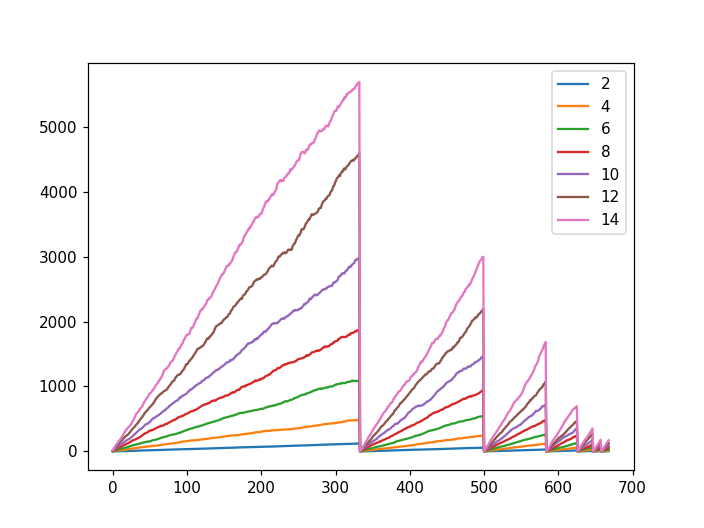

['0.8825 123.540', '0.9543 57.519', '0.9736 30.440', '0.8801 15.626', '0.9001 8.244', '0.8209 8.244']
['1.0613 485.282', '0.8638 241.902', '0.8898 123.175', '0.9150 60.305', '0.8986 29.854', '0.8594 29.854']
['0.7032 1092.642', '0.8489 548.909', '0.7890 262.392', '0.9068 128.871', '0.9757 67.092', '0.9682 67.092']
['0.8183 1868.196', '1.0312 943.866', '0.9285 481.924', '0.8758 247.197', '0.9619 107.468', '0.8664 107.468']
['1.1203 2977.676', '0.8242 1467.748', '0.9188 720.436', '0.9066 357.324', '0.8680 171.494', '0.8680 171.494']
['0.8742 4590.994', '0.7630 2190.850', '1.0092 1075.473', '0.7424 471.699', '0.9033 272.370', '0.9033 272.370']
['0.6366 5687.942', '0.7396 2995.163', '0.8988 1684.257', '0.8867 697.818', '0.8544 353.395', '0.8544 353.395']


In [44]:
print(np.array(V_sets).shape)
fig, ax = plt.subplots()
# sigmas_vel = [(jdx+1)*2 for jdx in range(3)]
for i in range(len(V_sets)):
    v = np.mean(V_sets[i], axis=0)
#     v = V_sets[i][0]
    t = np.array([x*dt for x in range(int(T_end/dt))])
    ax.plot(v, label='{}'.format(sigmas[i]))
#     ax.plot(t,v[0]+t*dt*(sigmas[i])**2, label='{}-est'.format(sigmas[i]))
# ax.plot(t,v)
ax.legend()
for i in range(len(V_sets)):
    v = np.mean(V_sets[i], axis=0)
#     v = V_sets[i][0]
    mean = np.array([1/2, 3/4, 7/8, 15/16, 31/32,63/64]) * T_end/dt
    mean = mean.astype(int)
    ranges = 10
    print(['{:.4f} {:.3f}'.format(np.min(v[mean[idx]-ranges:mean[idx]+ranges]), 
                                  np.max(v[mean[idx]-ranges:mean[idx]+ranges])) for idx in range(len(mean))])


<IPython.core.display.Javascript object>


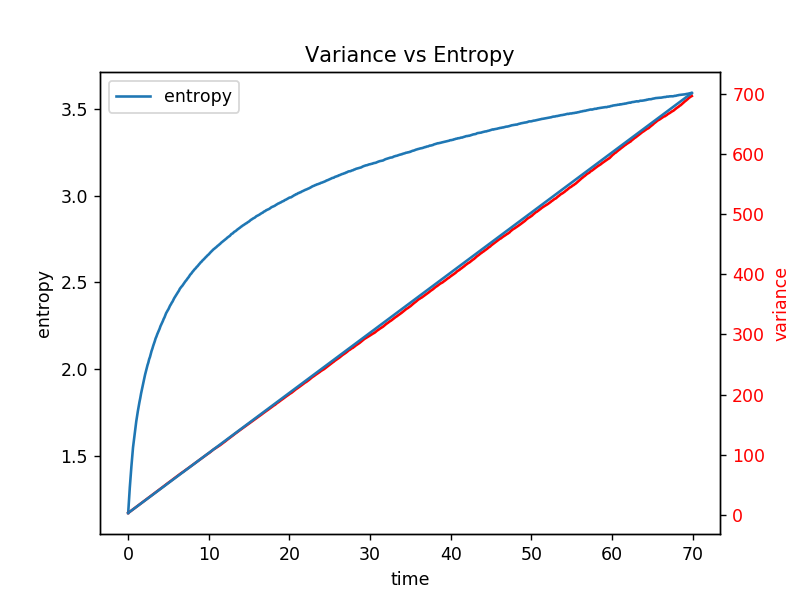

In [19]:
h = np.mean(H, axis=0)
v=np.mean(V, axis=0)
t = np.array([x*dt for x in range(int(T_end/dt))])
p = (1/np.sqrt(2*np.pi*v))*np.exp(-.5*(1/v))
entropy_est = -np.log(p)
fig, ax = plt.subplots()
ax.plot(t,h, label='entropy')
# ax.plot(np.log(np.array(v)), label='log of variance')
# ax.plot(t,entropy_est - (entropy_est[0]-h[0]),label='probability')
ax.legend()
ax.set_ylabel('entropy')
ax.set_xlabel('time')
ax.set_title("Variance vs Entropy")

ax2 = ax.twinx()
ax2.plot(t,v, color='r')
ax2.plot(t,v[0]+10*t*(dt*sigma_vel)**2)
ax2.set_ylabel('variance', color='r')
ax2.tick_params(axis='y', labelcolor='r')